# Example `alphatools` workflow with proteomics data

This notebook demonstrates core `alphatools` functionality for proteomics data loading, preprocessing and visualization. 

Functionalities are intended to be as close to pure python as possible, avoiding closed end-to-end implementations, which is reflected in several design choices: 

1. AnnData is used in favor of a custom data class to enable interoperability with any other tool from the Scverse.
2. matplotlib *Axes* and *Figure* instances are used for visualization, giving the user full autonomy to layer on custom visualizations with searborn, matplotlib, or any other compatible visualization package.
3. Statistical and preprocessing functions are standalone and set with strong defaults, meaning that any function can be used outside of the `alphatools` context. 

### Design choices of `alphatools`:
- **Data handling**: `AnnData` was chosen as a data container for two main reasons: 1) For presenting a lightweight, powerful solution to a fundamental challenge with dataframes, which is keeping numerical data and metadata aligned together at all times. Using dataframes, the options are to either include non-numeric metadata columns in the dataframe, complicating data operations, or to add cumbersome multi-level indices and 2) For their compatibility with the Scverse, Scanpy and all associated tools, essentially removing the barrier between proteomics and transcriptomics data analysis and enabling multi-omics analyses. 
- **Plotting**: Inspired by the [`stylia`] package, we provide a consistent design throughout `alphatools`, aiming to provide a consistent and aesthetically pleasing visual experience for all plots. A core component of this implementation is the fact that `create_figure` returns subplots as an iterable data structure, meaning that once the basic layout of a plot is decided, users simply jump from one plot window to the next and populate each one with figure elements. 
- **Standardization**: A key consideration of this package is the loading of proteomics data, the biggest painpoint of which is the nonstandard output of various proteomic search enginges. By building on `alphabase`, we handle this complexity early and provide the user with AnnData objects containing either proteins or precursors, which on the one hand can be converted to metadata containing dataframes nearly frictionless by running `df = adata.to_df().join(adata.obs)` and on the other hand are compatible with any foreseeable downstream analysis task.

[`stylia`]: https://github.com/ersilia-os/stylia.git

### An example dataset: Alzheimer study

AlphaTools is designed to perform two main functions: First, provide a unified interface between search engine outputs and downstream processing. Second, provide downstream proteomics workflows entirely compatible with transcriptomics and the AnnData framework. Below we step through an `alphatools` example by using a published dataset by Bader et al. [2], who measured cerebrospinal fluid proteomes in order to discover biomarkers for Alzheimer's disease.

[2]: Bader, Jakob M., et al. "Proteome profiling in cerebrospinal fluid reveals novel biomarkers of Alzheimer's disease." Molecular systems biology 16.6 (2020): e9356.

In [ ]:
%load_ext autoreload
%autoreload 2

import tempfile

import numpy as np
import pandas as pd
from alphabase.tools.data_downloader import DataShareDownloader

# Data handling
from alphatools.io.anndata_factory import AnnDataFactory
from alphatools.pp.data import add_metadata, filter_by_metadata, filter_data_completeness
from alphatools.pp.transform import nanlog
from alphatools.pp.impute import impute_gaussian
from alphatools.pp.embeddings import pca

from alphatools.pl.plots import Plots, add_lines, label_plot
from alphatools.pl.figure import create_figure, label_axes, save_figure
from alphatools.pl.colors import BaseColors, BasePalettes, BaseColormaps

INFO:rdkit:Enabling RDKit 2024.03.3 jupyter extensions


### 1. Prepare the dataset using `alphatools` loaders and AnnData factory. 

The full output of a DIANN search is saved as a report file of precursors, from which precursor or protein-level data can be extracted. This is an unfiltered table, and false-discovery-control for first and second search passes must be applied. `alphatools` handles this filtering with its AnnData factory class, based on `alphabase`. The resulting AnnData object contains precursor, protein-group or gene quantities and any number of feature-metadata columns (for example, protein groups may have genes as secondary annotation, precursors may have protein groups and genes as secondary annotation).

In [ ]:
# Download the dataset
url = "https://datashare.biochem.mpg.de/s/zNtxEQJTdqQYLd4"
with tempfile.TemporaryDirectory() as temp_dir:
    file_path = DataShareDownloader(url=url, output_dir=temp_dir).download()
    factory = AnnDataFactory.from_files(file_paths=file_path, reader_type="diann")

# Create the AnnData object, where the row index corresponds to samples and the column names correspond to proteins
adata = factory.create_anndata()

# Use the builtin dataframe conversion to get a quick overview of the data
display(adata.to_df().iloc[:5, :5])

# Protein abundances are still in actual values. It is common to log-transform them prior to analysis.
# We get a warning that our data contains NaN values, which are ignored in the log-transform.
# When verbosity is set to 1, 'nanlog()' alerts to special values for which log-transformation is not possible.
adata = nanlog(adata, base=2, verbosity=1)

/var/folders/2l/hhd_z4hx3070zw8rlj4c3l940000gn/T/tmp33thdcl9/report.parquet does not yet exist


100% |########################################################################|


/var/folders/2l/hhd_z4hx3070zw8rlj4c3l940000gn/T/tmp33thdcl9/report.parquet successfully downloaded (91.135817527771 MB)


/Users/vincenthbrennsteiner/Documents/mann_labs/_git_repositories/alphatools/src/alphatools/io/anndata_factory.py:46: UserWarning: Found 846848 duplicated features. Using only first.
  warnings.warn(


proteins,1433B-2_HUMAN;1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433T_HUMAN
raw_name,,,,,
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA01,5898647.0,7653369.5,198099.203125,5859688.5,240594.546875
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA02,6674590.5,6645735.0,237327.343750,5854608.0,288184.968750
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA03,5213923.5,3370416.0,145326.515625,4977316.0,184137.562500
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA04,4843322.5,5707478.5,149581.875000,5262512.0,124084.984375
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA05,7309056.0,7943046.0,230455.875000,7263083.0,315826.812500


### 2. Integrate the study metadata

The AnnData format provides a solution to a key problem encountered in every data-analysis project: How to keep a matrix of numerical values permanently and safely aligned with column and row annotations. This is notably difficult with dataframes, as multilevel column indices are cumbersome and non-numeric columns in one dataframe cause problems with downstram analyses methods that expect numerical features. The _*add_metadata*_ function ensures alignment of observations and variables from the start.

☝️ Importantly, while the original AnnData implementation only enforces shape compatibility, `alphatools.pp.data.add_metadata()` enforces matching indices. This means that even if the initial data and the incoming metadata were to be in different orders, the correct proteomic and metadata information for a given sample are always matched. 

In [ ]:
# Download the metadata
url = "https://datashare.biochem.mpg.de/s/iSgdPnHgczbcktF"
with tempfile.TemporaryDirectory() as temp_dir:
    file_path = DataShareDownloader(url=url, output_dir=temp_dir).download()
    metadata = pd.read_excel(file_path).dropna(subset=["sample name"])

/var/folders/2l/hhd_z4hx3070zw8rlj4c3l940000gn/T/tmpw8eb8fs3/annotation%20of%20samples_AM1.5.11.xlsx does not yet exist
/var/folders/2l/hhd_z4hx3070zw8rlj4c3l940000gn/T/tmpw8eb8fs3/annotation%20of%20samples_AM1.5.11.xlsx successfully downloaded (0.028104782104492188 MB)


100% |########################################################################|


In [ ]:
# Basic cleaning of the metadata prior to merging
metadata["sample name"] = metadata["sample name"].str.replace(".raw.PG.Quantity", "", regex=False)
metadata = metadata.set_index("sample name", drop=False)

# The metadata contains information for more samples than are in our data
print(f"AnnData shape: {adata.shape}")
print(f"Metadata shape: {metadata.shape}")

# Match the metadata to the AnnData object
print(f"Anndata shape prior to matching: {adata.shape}")
adata = add_metadata(
    adata=adata,  # The AnnData object we want to add metadata to. Its obs index should match the index of the metadata
    incoming_metadata=metadata,  # The metadata dataframe we want to add. Its index should match the index of adata.obs
    axis=0,  # This means that we add metadata to the rows (0) and not columns (1)
    keep_data_shape=False,  # This means that we will drop any samples for which there is no corresponding row in the metadata
)
print(f"Anndata shape after matching: {adata.shape}")
print()

# From now on, the metadata is stored in adata.obs
print("The sample-level metadata:")
display(adata.obs.head())

# For now, the feature (i.e. protein) metadata is a dataframe with only one column. We could easily add more protein annotations like GO-terms to it
print("The feature-level metadat:")
display(adata.var.head())

# And the protein abundances are stored in adata.X, which is a numpy array and perfectly suited for numerical operations
print("The protein abundances:")
display(adata.X[:5, :5])

AnnData shape: (61, 2162)
Metadata shape: (210, 14)
Anndata shape prior to matching: (61, 2162)
Anndata shape after matching: (61, 2162)

The sample-level metadata:


,sample name,collection site,age,gender,t-tau [ng/L],p-tau [ng/L],Abeta-42 [ng/L],Abeta-40 [ng/L],Abeta ratio,biochemical AD classification,clinical AD diagnosis,MMSE score,cohort sample ID,comment
raw_name,,,,,,,,,,,,,,
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA01,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,Sweden,71.0,f,703.0,85.0,562.0,NaN,NaN,biochemical control,NaN,NaN,ID_708,NaN
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA02,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,Sweden,77.0,m,518.0,91.0,334.0,NaN,NaN,biochemical AD,NaN,NaN,ID_722,NaN
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA03,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,Sweden,75.0,m,974.0,87.0,515.0,NaN,NaN,biochemical AD,NaN,NaN,ID_734,NaN
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA04,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,Sweden,72.0,f,950.0,109.0,394.0,NaN,NaN,biochemical AD,NaN,NaN,ID_742,NaN
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA05,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,Sweden,63.0,f,873.0,88.0,234.0,NaN,NaN,biochemical AD,NaN,NaN,ID_757,NaN


The feature-level metadat:


""
proteins
1433B-2_HUMAN;1433B_HUMAN
1433E_HUMAN
1433F_HUMAN
1433G_HUMAN
1433T_HUMAN


The protein abundances:


array([[22.491953, 22.867664, 17.595863, 22.482393, 17.876244],
       [22.670248, 22.663998, 17.85652 , 22.481142, 18.136635],
       [22.313938, 21.684496, 17.14894 , 22.246937, 17.490425],
       [22.207565, 22.444422, 17.190577, 22.32732 , 16.920969],
       [22.801254, 22.92126 , 17.81413 , 22.79215 , 18.268774]],
      dtype=float32)

### 3. Generate an overview of the metadata

In order to understand the properties of our data, we may want to generate overviews of certain columns in the metadata. To do this quick and publication-ready, we utilize `alphatools.pl.plots.Plots` and its asssociated functionalities.

INFO:root:Column 'age' found in: data.obs.columns. Using that
INFO:root:Column 't-tau [ng/L]' found in: data.obs.columns. Using that
INFO:root:Column 'p-tau [ng/L]' found in: data.obs.columns. Using that
INFO:root:Column 'Abeta-42 [ng/L]' found in: data.obs.columns. Using that


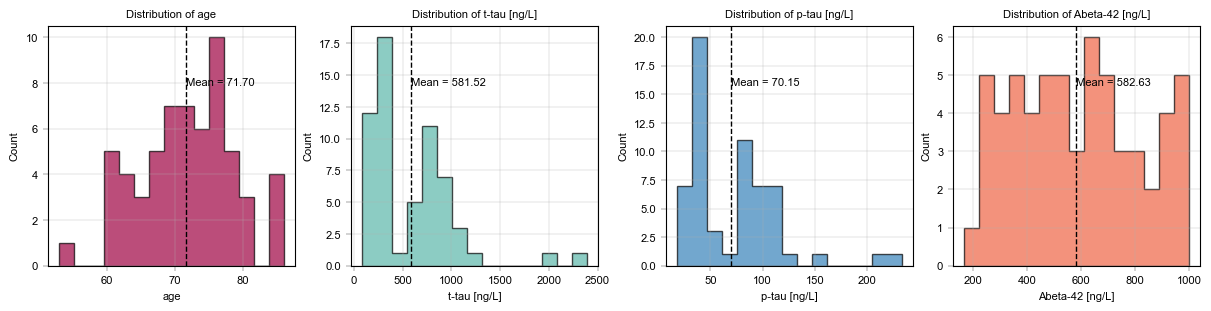

In [ ]:
# Check distribution of age and other numerical columns
numerical_columns = ["age", "t-tau [ng/L]", "p-tau [ng/L]", "Abeta-42 [ng/L]"]
fig, facettes = create_figure(1, len(numerical_columns), figsize=(3 * len(numerical_columns), 3))

# Generate a dictionary with default colors
palette = BasePalettes.get("qualitative", n=len(numerical_columns))
color_dict = dict(zip(numerical_columns, palette, strict=False))

for col in numerical_columns:
    ax = facettes.next()  # Go to the next facette of the plot
    Plots.histogram(
        ax=ax,
        bins=15,
        data=adata,
        value_column=col,
        color=color_dict[col],
        # Add whatever flourish we want for the histograms
        hist_kwargs={
            "histtype": "stepfilled",
            "alpha": 0.7,
            "edgecolor": "black",
        },
    )

    # Label the individual axes
    label_axes(
        ax=ax,
        xlabel=col,
        ylabel="Count",
        title=f"Distribution of {col}",
    )

    # Indicate means with a vertical line
    mean = adata.obs[col].mean()
    add_lines(
        ax=ax,
        intercepts=mean,
        linetype="vline",
        color="black",
    )

    # Add a label for each mean
    label_plot(
        ax=ax,
        x_values=[mean],
        y_values=[0.75],
        labels=[f"Mean = {mean:.2f}"],
        # The code below essentially means "Use data coordinates for the x-axis, but use axes coordinates (0-1) for the y-axis".
        label_kwargs={"transform": ax.get_xaxis_transform()},
    )

    # TODO: Easy adding of A, B, C, ... plot enumeration in the top left corner of each facette

    # Since the figure size is fixed from the initial generation of the subplot, we can save it looking exactly as we see below in the notebook
    save_figure(
        fig=fig,  # Note that here we're using the whole figure to whose axes we added our plots
        filename="continuous_var_overview.svg",
        output_dir="./example_outputs",
    )

    # TODO: Implement barplots for categorical variables.

INFO:root:Column 'protein_count' found in: data.obs.columns. Using that


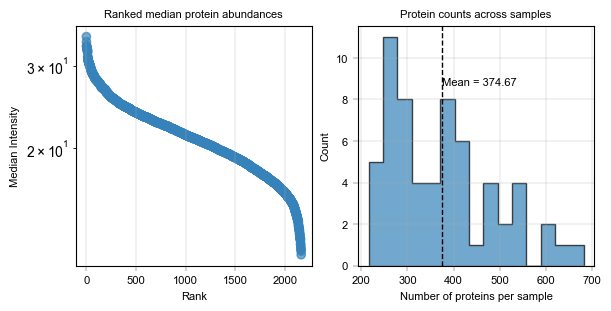

In [ ]:
# Generate a ranked plot of median intensities
fig, facettes = create_figure(1, 2, figsize=(6, 3))

# First, show the protein values
ax = facettes.next()
Plots.rank_median_plot(
    data=adata,
    ax=ax,
    color=BaseColors.get("blue"),
    scatter_kwargs={
        "alpha": 0.7,
    },
)
label_axes(
    ax=ax,
    title="Ranked median protein abundances",
)

# Next, show the protein count per sample
adata.obs["protein_count"] = np.isnan(adata.X).sum(axis=1)  # Count non-missing values
ax = facettes.next()
Plots.histogram(
    ax=ax,
    data=adata,
    value_column="protein_count",
    bins=15,
    color=BaseColors.get("blue"),
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
    },
)
label_axes(
    ax=ax,
    xlabel="Number of proteins per sample",
    ylabel="Count",
    title="Protein counts across samples",
)

mean_protein_count = adata.obs["protein_count"].mean()

add_lines(
    ax=ax,
    intercepts=mean_protein_count,
    linetype="vline",
    color="black",
)

label_plot(
    ax=ax,
    x_values=[mean_protein_count],
    y_values=[0.75],
    labels=[f"Mean = {mean_protein_count:.2f}"],
    label_kwargs={"transform": ax.get_xaxis_transform()},
)

# And lastly

# TODO: CV plot to show the variability of proteins per sample group

# TODO: Barplot to show protein numbers

# TODO: Where are the horizontal gridlines in the log-transformed ranked plot?

# TODO: Fix axes: We want better labels, there should always be e.g. 5 labels at decent intervals. Matplotlib is bad at this and may produce a plot with only one or two tick labels per axis

### 4. Filter study data based on metadata

In order to analyse subcohorts of the study, it can be useful to filter by a metadata variable like age or gender. `alphatools` offers an intuitive way to do so via `alphatools.pp.data.filter_by_metadata()`, which takes a dictionary of filter conditions returns a subsetted AnnData object. While filtering AnnData objects with familiar pandas/numpy slicing is possible, we found that applying multiple filters and filters based on ranges of data can get cumbersome, as illustrated by an example. Consider a dataset like this:

In [ ]:
import anndata as ad

X = pd.DataFrame(
    {
        **{f"gene_{i}": np.random.randn(6) for i in range(5)},
    },
    index=[f"cell_{i}" for i in range(6)],
)

sample_metadata = pd.DataFrame(
    {
        "column1": ["A", "B", "C", "D", "E", "F"],
        "column2": [50, 200, 50, 200, 50, 200],
    }
)

test_adata = ad.AnnData(X)
test_adata.obs = sample_metadata

# Instead of this, which is quite convoluted as more columns are added
adata_filtered_1 = test_adata[
    (test_adata.obs["column1"].isin(["A", "B", "C"]))
    | ((test_adata.obs["column2"] > 20) & (test_adata.obs["column2"] <= 100)),  # NOQA: PLR2004
    :,
]

# We use this for easy and transparent filtering
adata_filtered_2 = filter_by_metadata(
    test_adata, {"column1": ["A", "B", "C"], "column2": (20, 100)}, axis=0, logic="or", action="keep"
)
if not adata_filtered_1.obs.equals(adata_filtered_2.obs):
    raise ValueError("The two filtering methods did not produce the same result!")

### Examine the PCA clustering of data, colored by different variables

PCA values are computed and saved to the same AnnData instance, making use of its `obsm`, `varm`, and `uns` (unstructured) data fields.

In [ ]:
# We restrict our dataset to proteins with no more than 25 % missing values across all samples
adata_25pc = filter_data_completeness(
    adata=adata,
    max_missing=0.25,
)

# We impute the remaining missing values from a downshifted gaussian distribution
adata_25pc = impute_gaussian(
    adata=adata_25pc,
)

# Add PCA embeddings to the AnnData object by utilizing its 'obsm' attribute
pca(adata_25pc, n_comps=10)

# Locating the PCA results
print("\nPCA Components: adata.obsm['X_pca'] with shape (n_obs x n_comps):")
print(adata_25pc.obsm["X_pca_obs"].shape)

print("\nPCA loadings: adata.varm['PCs'] with shape (n_var x n_comps):")
print(adata_25pc.varm["PCs_obs"].shape)

print("\nRatio of explained variance: uns['pca']['variance_ratio'] with shape (n_comps,):")
print(adata_25pc.uns["variance_pca_obs"]["variance_ratio"])

print("\nExplained variance: uns['pca']['variance'] with shape (n_comps):")
print(adata_25pc.uns["variance_pca_obs"]["variance"])

INFO:root:pp.filter_data_completeness(): Dropped 533 / 2162 features with >0.25 missing in any group.
INFO:root:Imputation complete. Imputed 2837 NaN values with Gaussian distribution.
INFO:alphatools.pp.embeddings:computing PCA



PCA Components: adata.obsm['X_pca'] with shape (n_obs x n_comps):
(61, 10)

PCA loadings: adata.varm['PCs'] with shape (n_var x n_comps):
(1629, 10)

Ratio of explained variance: uns['pca']['variance_ratio'] with shape (n_comps,):
[0.24341215 0.09301776 0.05434335 0.0436245  0.04022673 0.03490534
 0.02737732 0.02610736 0.02208371 0.02114128]

Explained variance: uns['pca']['variance'] with shape (n_comps):
[189.4765    72.40674   42.30186   33.958115  31.313225  27.170956
  21.311007  20.322453  17.190369  16.45676 ]


/Users/vincenthbrennsteiner/miniconda3/envs/alphaverse/lib/python3.11/site-packages/debugpy/_vendored/pydevd/pydev_ipython/matplotlibtools.py:59: MatplotlibDeprecationWarning: The interactive_bk attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin(matplotlib.backends.BackendFilter.INTERACTIVE)`` instead.
  from matplotlib.rcsetup import interactive_bk, non_interactive_bk  # @UnresolvedImport
/Users/vincenthbrennsteiner/miniconda3/envs/alphaverse/lib/python3.11/site-packages/debugpy/_vendored/pydevd/pydev_ipython/matplotlibtools.py:59: MatplotlibDeprecationWarning: The non_interactive_bk attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin(matplotlib.backends.BackendFilter.NON_INTERACTIVE)`` instead.
  from matplotlib.rcsetup import interactive_bk, non_interactive_bk  # @UnresolvedImport


ValueError: could not convert string to float: 'NA'

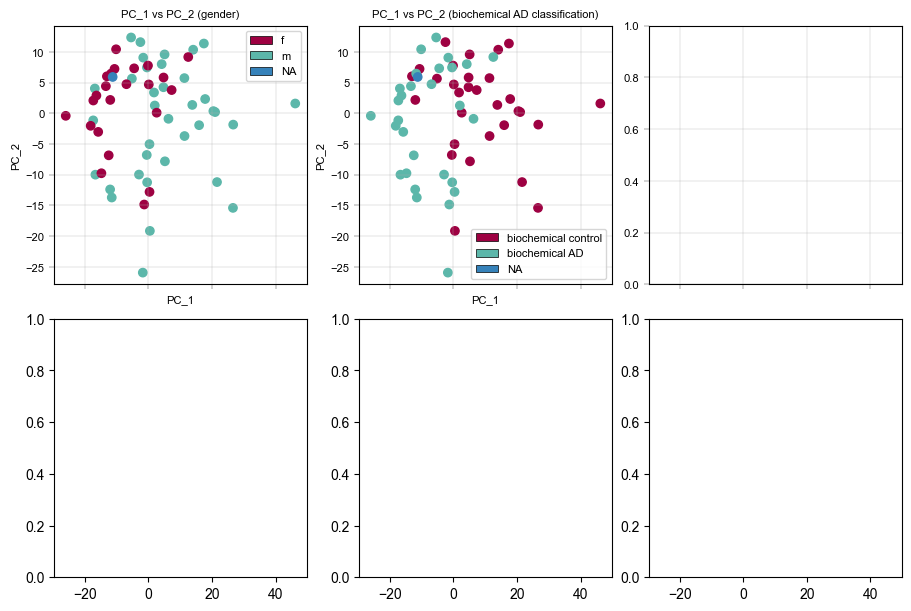

In [ ]:
# Visualizing the PCA results
fig, facettes = create_figure(2, 3, figsize=(9, 6), subplots_kwargs={"sharex": True})

# We can get the PCA component values into a dataframe
# TODO: Better abstraction for this in general, i.e. getting a dataframe with metadata out of the AnnData instance
# TODO: Special function to get the PCA dataframe with adequate component names
pca_df = pd.DataFrame(
    adata_25pc.obsm["X_pca_obs"],
    index=adata_25pc.obs.index,
    columns=[f"PC_{i + 1}" for i in range(adata_25pc.obsm["X_pca_obs"].shape[1])],
)
pca_df = pca_df.join(adata_25pc.obs)

# Color by gender
ax = facettes.next()
Plots.scatter(
    ax=ax,
    data=pca_df,
    x_column="PC_1",
    y_column="PC_2",
    color_map_column="gender",
    legend="auto",
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="PC_2",
    title="PC_1 vs PC_2 (gender)",
)

# TODO: Scatter should have an additional x_labels and y_labels argument, making it possible to pass ranking information to x_values and a_values but display categorical levels of interest.

# Color by biochemical AD classification
ax = facettes.next()
Plots.scatter(
    ax=ax,
    data=pca_df,
    x_column="PC_1",
    y_column="PC_2",
    color_map_column="biochemical AD classification",
    legend="auto",
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="PC_2",
    title="PC_1 vs PC_2 (biochemical AD classification)",
)

# Color by age
# TODO: Legend with small colorbar when a colormap is used
ax = facettes.next()
Plots.scatter(
    ax=ax,
    data=pca_df,
    x_column="PC_1",
    y_column="PC_2",
    color_map_column="age",
    palette=BaseColormaps.get("sequential"),
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="PC_2",
    title="PC_1 vs PC_2 (age)",
)

# TODO: add_labels should work on anndata directly

# Go on and add histograms for first component
ax = facettes.next()
Plots.histogram(
    ax=ax,
    data=pca_df,
    value_column="PC_1",
    color_map_column="gender",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
    },
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="Count",
)

ax = facettes.next()
Plots.histogram(
    ax=ax,
    data=pca_df,
    value_column="PC_1",
    color_map_column="biochemical AD classification",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
    },
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="Count",
)

ax = facettes.next()
Plots.histogram(
    ax=ax,
    data=pca_df,
    bins=15,
    value_column="PC_1",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
    },
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="Count",
)

### Or a more creative approach to one of the variables, e.g. Alzheimer's classification:


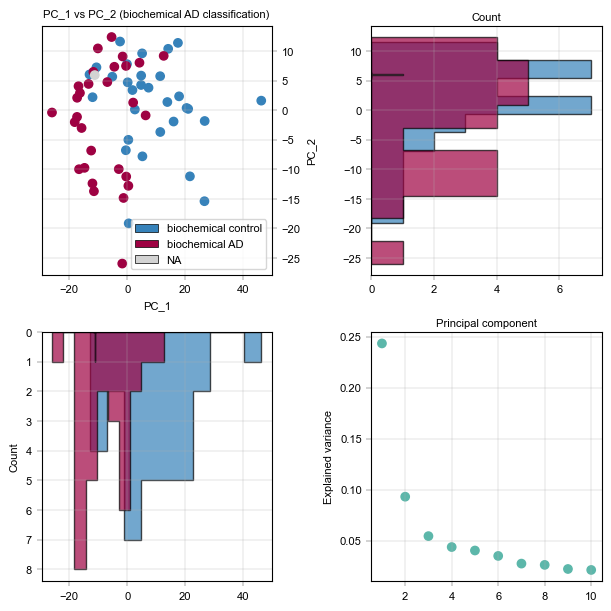

In [ ]:
# Visualizing the PCA results
fig, facettes = create_figure(2, 2, figsize=(6, 6))

# We can get the PCA component values into a dataframe
# TODO: Better abstraction for this in general, i.e. getting a dataframe with metadata out of the AnnData instance
# TODO: Special function to get the PCA dataframe with adequate component names
pca_df = pd.DataFrame(
    adata_25pc.obsm["X_pca"],
    index=adata_25pc.obs.index,
    columns=[f"PC_{i + 1}" for i in range(adata_25pc.obsm["X_pca"].shape[1])],
)
pca_df = pca_df.join(adata_25pc.obs)

# Ensure that the colors are the same across all plots
color_dict = {
    "biochemical control": BaseColors.get("blue"),
    "biochemical AD": BaseColors.get("red"),
    "NA": BaseColors.get("grey"),
}

# Color by biochemical AD classification
ax = facettes.next()
Plots.scatter(
    ax=ax,
    data=pca_df,
    x_column="PC_1",
    y_column="PC_2",
    color_map_column="biochemical AD classification",
    legend="auto",
    color_dict=color_dict,
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="PC_2",
    title="PC_1 vs PC_2 (biochemical AD classification)",
)
# Move the y-axis label to the right side of the plot
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# Go on and add 90 degree tilted histograms for the second component
ax = facettes.next()
Plots.histogram(
    ax=ax,
    data=pca_df,
    value_column="PC_2",
    color_map_column="biochemical AD classification",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
        "orientation": "horizontal",
    },
    color_dict=color_dict,
)
label_axes(
    ax=ax,
    xlabel="Count",
)
ax.xaxis.set_label_position("top")

# Add a histogram for the first component
ax = facettes.next()
Plots.histogram(
    ax=ax,
    data=pca_df,
    value_column="PC_1",
    color_map_column="biochemical AD classification",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
    },
    color_dict=color_dict,
)
label_axes(
    ax=ax,
    ylabel="Count",
)
ax.invert_yaxis()

# And lastly a scree plot to show the explained varince
ax = facettes.next()
Plots.scree_plot(
    ax=ax,
    data=adata_25pc,
    n_pcs=10,
    color=BaseColors.get("green"),
)
label_axes(
    ax=ax,
    xlabel="Principal component",
    ylabel="Explained variance",
)
ax.xaxis.set_label_position("top")

It appears there is separation of the Alzheimer's and control samples on the first principal component. We can examine the loadings of the first component to get an idea of which proteins are regulated.

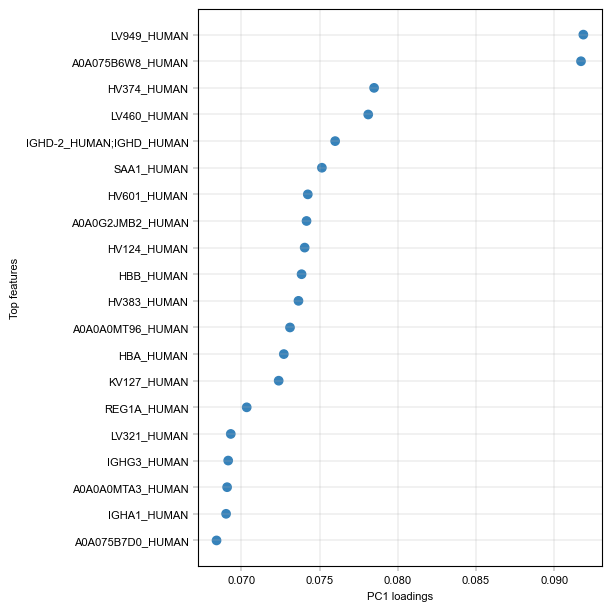

In [ ]:
fig, facettes = create_figure(1, 1, figsize=(6, 6))
# TODO: All plots should have an optional ax argument, e.g. if no ax is given, they should call create_figure(1,1) internally
Plots.plot_pca_loadings(
    data=adata_25pc,
    ax=facettes.next(),
    dim=1,
)

The two highest loadings on PC1 are LV949 and A0A075B6W8. We can take these along and check their differential abundance between treatments. 

In [ ]:
# TODO: As discussed, compute steps should be separated from the plotting steps. For example, if there were a function called "get_ordered_loadings_df" and a function "plot_ordered_loadings" instead of "plot_pca_loadings", it would be easier to extract the top loadings.

# TODO: Differential expression to compare proteins between groups, which could mark a preliminary checkpoint in the present analysis.